In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Função que transforma r em rho

def convert_r_rho(r):
    """
    Calcula o valor de rho com base na equação fornecida.

    Parâmetros:
    k  : float : constante k
    l0 : float : valor de l0
    l  : float : valor de l
    n  : float : expoente n

    Retorna:
    float : valor de rho
    """

    # Apatite Durango Spontaneous parameters
    k = 0.108
    l0 = 14.24 # micrometer
    sigma_l0 = 0.08 # micrometer
    n = 8
    return  (r * (1 - 1 / (1 + (k * l0 * r) ** n) ** 2))/(1 - 1 / (1 + (k * l0) ** n) ** 2)


def prop(r, ur):
    """
    Calcula o valor atualizado com base na fórmula fornecida.
    
    Parâmetros:
    r  : float : valor de r
    ur : float : incerteza associada a r
    
    Retorna:
    float : resultado da fórmula.
    """
    import numpy as np
    
    # Apatite Durango Spontaneous parameters
    k = 0.108
    l0 = 14.24  # micrometer
    ul0 = 0.08  # micrometer (incerteza associada a l0)
    n = 8  # expoente n

    # Componentes intermediários para simplificar o cálculo
    kl0 = k * l0
    kl0_r = kl0 * r
    term_kl0_n = (1 + kl0 ** n)
    term_kl0r_n = (1 + kl0_r ** n)

    # Derivados da fórmula fornecida
    numerador_1 = (
        (2 * k * n * r**2 * kl0_r**(-1 + n)) /
        ((1 - 1 / term_kl0_n**2) * term_kl0r_n**3)
    )
    numerador_2 = (
        (2 * k * kl0**(-1 + n) * n * r *
         (1 - 1 / term_kl0r_n**2)) /
        ((1 + kl0**n)**3 * (1 - 1 / term_kl0_n**2)**2)
    )
    term_ul0 = numerador_1 - numerador_2

    numerador_3 = (
        (2 * kl0 * n * r * kl0_r**(-1 + n)) /
        ((1 - 1 / term_kl0_n**2) * term_kl0r_n**3)
    )
    numerador_4 = (1 - 1 / term_kl0r_n**2) / (1 - 1 / term_kl0_n**2)
    term_ur = numerador_3 + numerador_4

    # Incertezas finais
    uncertainty_ul0 = term_ul0**2 * ul0**2
    uncertainty_ur = term_ur**2 * ur**2

    # Soma das incertezas e raiz quadrada para o resultado final
    resultado = np.sqrt(uncertainty_ul0 + uncertainty_ur)

    return resultado


def truncate_to_first_significant(value, uncertainty):
    """
    Trunca o valor para o mesmo número de casas decimais do primeiro algarismo significativo da incerteza.
    
    Args:
    - value (float): O valor principal a ser truncado.
    - uncertainty (float): A incerteza associada, usada para determinar o truncamento.

    Returns:
    - float: O valor truncado.
    """
    if uncertainty == 0:
        return value  # Nenhuma truncagem se a incerteza for 0.
    
    # Determina o número de casas decimais do primeiro algarismo significativo
    decimal_places = -int(np.floor(np.log10(abs(uncertainty))))
    
    # Aplica truncagem com base no número de casas decimais
    factor = 10 ** decimal_places
    return np.round(value * factor) / factor

def truncate_df_to_uncertainty(df, target_column, uncertainty_column):
    """
    Trunca os valores do DataFrame para o mesmo nível do primeiro algarismo significativo da incerteza.

    Args:
    - df (pd.DataFrame): DataFrame contendo as colunas de interesse.
    - target_column (str): Nome da coluna cujos valores serão truncados.
    - uncertainty_column (str): Nome da coluna de incertezas associadas.

    Returns:
    - pd.DataFrame: DataFrame com os valores truncados.
    """
    df[target_column] = df.apply(lambda row: truncate_to_first_significant(row[target_column], row[uncertainty_column]), axis=1)
    df[uncertainty_column] = df[uncertainty_column].apply(lambda x: truncate_to_first_significant(x, x))
    return df

# Reading Durango Data and KTB data
durango = pd.read_csv('DurangoDataR.txt', sep="\\s+", engine='python')
ktb = pd.read_csv('KTB.txt', sep="\\s+", engine='python')

# Truncando valores pela incerteza

durango = truncate_df_to_uncertainty(durango, target_column='r', uncertainty_column='e.r')
ktb = truncate_df_to_uncertainty(ktb, target_column='r', uncertainty_column='e.r')

print(durango)
print(ktb)


    tempoH  temperC      L   e.L   tempoS  temperK      r    e.r
0        1      125  16.40  0.05     3600   398.15  0.993  0.004
1        1      150  16.34  0.05     3600   423.15  0.989  0.004
2        1      150  16.35  0.05     3600   423.15  0.990  0.004
3        1      175  16.17  0.05     3600   448.15  0.979  0.004
4        1      176  16.17  0.05     3600   449.15  0.979  0.004
..     ...      ...    ...   ...      ...      ...    ...    ...
57    1000      250  12.88  0.05  3600000   523.15  0.780  0.004
58    1000      251  13.09  0.04  3600000   524.15  0.792  0.003
59    1000      275  11.53  0.06  3600000   548.15  0.698  0.004
60    1000      275  11.09  0.07  3600000   548.15  0.671  0.005
61    1000      275  11.31  0.07  3600000   548.15  0.685  0.005

[62 rows x 8 columns]
          tempoH  temperC        L       e.L        tempoS     temperK      r  \
0   5.697900e+11        0  14.6908  0.182927  2.051240e+15  273.590847  0.890   
1   5.697900e+11        0  14.8812 

In [2]:
# Durango Data
dataDurango = durango.iloc[:, [4, 5, 6, 7]]
dataDurango.loc[:,'r'] = convert_r_rho(durango['r'])
dataDurango = dataDurango.rename(columns={'r': 'rho'})
dataDurango.loc[:,'e.r'] = prop(durango['r'],durango['e.r'])
dataDurango = dataDurango.rename(columns={'e.r': 'e.rho'})
dataDurango = truncate_df_to_uncertainty(dataDurango, target_column='rho', uncertainty_column='e.rho')


print(dataDurango)

# KTB Data (Only for reference)

dataKTB = ktb.iloc[:, [4, 5, 6, 7]]
dataKTB.loc[:,'r'] = convert_r_rho(ktb['r'])
dataKTB = dataKTB.rename(columns={'r': 'rho'})
dataKTB.loc[:,'e.r'] = prop(ktb['r'],ktb['e.r'])
dataKTB = dataKTB.rename(columns={'e.r': 'e.rho'})
dataKTB = truncate_df_to_uncertainty(dataKTB, target_column='rho', uncertainty_column='e.rho')

print(dataKTB)

     tempoS  temperK    rho  e.rho
0      3600   398.15  0.993  0.004
1      3600   423.15  0.989  0.004
2      3600   423.15  0.990  0.004
3      3600   448.15  0.979  0.004
4      3600   449.15  0.979  0.004
..      ...      ...    ...    ...
57  3600000   523.15  0.753  0.006
58  3600000   524.15  0.770  0.004
59  3600000   548.15  0.610  0.010
60  3600000   548.15  0.540  0.010
61  3600000   548.15  0.580  0.010

[62 rows x 4 columns]
          tempoS     temperK    rho  e.rho
0   2.051240e+15  273.590847  0.890  0.010
1   2.051240e+15  276.753772  0.900  0.010
2   2.051240e+15  280.084639  0.870  0.010
3   2.051240e+15  284.926992  0.898  0.010
4   2.051240e+15  290.609059  0.904  0.008
5   2.051240e+15  293.660022  0.890  0.010
6   2.051240e+15  304.408366  0.900  0.010
7   2.051240e+15  304.884204  0.870  0.010
8   2.051240e+15  307.067461  0.889  0.010
9   2.051240e+15  312.833500  0.869  0.010
10  2.051240e+15  315.632548  0.853  0.008
11  2.051240e+15  318.347625  0.856  0.00

In [3]:
# Modelos de Annealing

# Paralelo-Arrhenius
def f_PA(tT, c0, c1, c2):
    import numpy as np
    t, T = tT
    R = 1.987204258 * 10**-3  # Constante dos gases em kcal/(mol*K)
    return c0 + c1 * np.log(t) + c2 / (R * T)
def lnt_PA(T, rho, params):
    import numpy as np
    c0, c1, c2 = params
    R = 1.987204258*10**-3  # Constante dos gases em kcal/(mol*K)
    return np.log(1-rho)/c1 - (c2/c1)/(R*T) - c0/c1

# Paralelo-Curvilinear
def f_PC(tT, c0, c1, c2):
    import numpy as np
    t, T = tT
    R = 1.987204258 * 10**-3  # Constante dos gases em kcal/(mol*K)
    return c0 + c1 * np.log(t) + c2*np.log(1/(R*T))
def lnt_PC(T, rho, params):
    import numpy as np
    c0, c1, c2 = params
    R = 1.987204258*10**-3  # Constante dos gases em kcal/(mol*K)
    return np.log(1-rho)/c1 - (c2/c1)*np.log(1/(R*T)) - c0/c1

# Fanning-Arrhenius
def f_FA(tT, c0, c1, c2, c3):
    import numpy as np
    t, T = tT
    R = 1.987204258 * 10**-3  # Constante dos gases em kcal/(mol*K)
    return c0 + c1 * (np.log(t) - c2) / (1 / (R * T) - c3)
def lnt_FA(T, rho, params):
    import numpy as np
    c0, c1, c2, c3 = params
    R = 1.987204258*10**-3  # Constante dos gases em kcal/(mol*K)
    return (c1 * c2 * R * T + c0 * (-1 + c3 * R * T) + (1 - c3 * R * T) * np.log(1 - rho)) / (c1 * R * T)

# Fanning-Arrhenius
def f_FC(tT, c0, c1, c2, c3):
    import numpy as np
    t, T = tT
    R = 1.987204258 * 10**-3  # Constante dos gases em kcal/(mol*K)
    return c0 + c1 * (np.log(t) - c2) / (np.log(1 / (R * T)) - c3)
def lnt_FC(T, rho, params):
    import numpy as np
    c0, c1, c2, c3 = params
    R = 1.987204258*10**-3  # Constante dos gases em kcal/(mol*K)
    return (c1 * c2 + c0 * c3 - c3 * np.log(1 - rho) + 
              np.log(1 / (R * T)) * (-c0 + np.log(1 - rho))) / c1




In [16]:
def DAM_fit(model, initial_params, lnt_model):
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from scipy.optimize import curve_fit
    
    # Dados
    t_data = dataDurango['tempoS']
    T_data = dataDurango['temperK']
    rho_data = dataDurango['rho']
    f_data = np.log(1 - rho_data)
    sigma_f = (dataDurango['e.rho'] / (1 - rho_data))
    
    # Ajuste de curva com a função model
    params, covariance = curve_fit(
        model,  # Função de ajuste
        (t_data, T_data),  # Dados de entrada como tupla
        f_data,  # Valores observados
        sigma=sigma_f,  # Incertezas associadas a f_data
        absolute_sigma=True,  # As incertezas são absolutas
        p0=initial_params  # Passando os valores iniciais
    )
    # Incertezas nos parâmetros (raízes quadradas da diagonal da matriz de covariância)
    param_errors = np.sqrt(np.diag(covariance))
    
    # Calculando a qualidade do ajuste: R² e Chi²
    f_fit = model((t_data, T_data), *params)
    residuals = f_data - f_fit
    ss_residual = np.sum(residuals**2)
    ss_total = np.sum((f_data - np.mean(f_data))**2)
    r_squared = 1 - (ss_residual / ss_total)
    
    # Calculando o valor de Chi²
    chi_squared = np.sum((residuals / sigma_f) ** 2)
    
    # Criando as tabelas
    param_names = ['c0', 'c1', 'c2', 'c3']  # Lista completa dos possíveis parâmetros
    
    # Ajustar a lista de parâmetros conforme o número de params ajustados
    if len(params) == 3:  # Se a função só tem c0, c1, e c2
        param_names = param_names[:3]  # Pegue os três primeiros parâmetros
    
    # Criar o DataFrame dinamicamente
    param_table = pd.DataFrame({
        'Parâmetro': param_names,
        'Valor Ajustado': params,
        'Incerteza': param_errors
    })
    # Tabela de qualidade do ajuste
    quality_table = pd.DataFrame({
        'Parâmetro': ['R²', 'Chi²'],
        'Valor': [r_squared, chi_squared]
    })
    
    # Exibindo as tabelas
    print("Tabela de Constantes de Ajuste e Incertezas:")
    print(param_table)
    
    print("\nTabela de Qualidade do Ajuste:")
    print(quality_table)

    # Plot dos resíduos
    plt.figure(figsize=(8, 6))
    plt.errorbar(f_fit, residuals, yerr=sigma_f, fmt='o', color='blue', label='Resíduos', ecolor='red', capsize=3)
    plt.axhline(0, color='black', linestyle='--', linewidth=1, label='Linha base (0)')
    plt.xlabel('Valores Ajustados (f_fit)')
    plt.ylabel('Resíduos (f_data - f_fit)')
    plt.title('Gráfico de Resíduos')
    plt.legend()
    plt.grid(True, linestyle='--', linewidth=0.5)
    filename1 = f"Residuos_{model.__name__}_1.png"  # Nome para o primeiro gráfico
    plt.savefig(filename1, dpi=300, bbox_inches='tight')
    plt.show()
    
    
    # Plot Data in Pseudo-Arrhenius Parallel Arrhenius
    import numpy as np
    from scipy.optimize import curve_fit
    import matplotlib.pyplot as plt
    
    dDKTB = pd.concat([dataDurango, dataKTB], ignore_index=True)
    
    # Separando os dados em rho
    
    y1 = np.log(dDKTB.loc[dDKTB['rho'] > 0.9 , 'tempoS'])
    y2 = np.log(dDKTB.loc[(dDKTB['rho'] > 0.8) & (dDKTB['rho'] <= 0.9), 'tempoS'])
    y3 = np.log(dDKTB.loc[(dDKTB['rho'] > 0.7) & (dDKTB['rho'] <= 0.8), 'tempoS'] )
    y4 = np.log(dDKTB.loc[(dDKTB['rho'] > 0.6) & (dDKTB['rho'] <= 0.7), 'tempoS'])
    
    x1 = 1000/dDKTB.loc[dDKTB['rho'] > 0.9 ,  'temperK']
    x2 = 1000/dDKTB.loc[(dDKTB['rho'] > 0.8) & (dDKTB['rho'] <= 0.9),  'temperK']
    x3 = 1000/dDKTB.loc[(dDKTB['rho'] > 0.7) & (dDKTB['rho'] <= 0.8),  'temperK']
    x4 = 1000/dDKTB.loc[(dDKTB['rho'] > 0.6) & (dDKTB['rho'] <= 0.7),  'temperK']
    
    plt.scatter(x1, y1, s=50, c='black', marker='^', edgecolor='black', alpha=0.7, label=r'$\rho$ > 0.9')
    plt.scatter(x2, y2, s=50, c='gray', marker='o', edgecolor='black', alpha=0.7,  label=r'0.8 < $\rho$ $\leq$ 0.9')
    plt.scatter(x3, y3, s=50, c='black', marker='s', edgecolor='black', alpha=0.7, label=r'0.7 < $\rho$ $\leq$ 0.8')
    plt.scatter(x4, y4, s=50, c='gray', marker='D', edgecolor='black', alpha=0.7, label=r'0.6 < $\rho$ $\leq$ 0.7')
    plt.xlabel(r'1000/T, $K^{-1}$')
    plt.ylabel(r'$\ln(t)$, time in seconds')
    
    Temps =  np.linspace(293, 650, 100)
    plt.plot(1000/Temps, lnt_model(Temps, 0.55, params), color='blue', label = 'r = 0.55')  # Gráfico de linha com marcadores
    plt.plot(1000/Temps, lnt_model(Temps, 0.9, params), color='red', label = 'r = 0.9')  # Gráfico de linha com marcadores
    
    plt.legend()
    plt.grid(True, color='gray', linestyle='--', linewidth=0.5)  # Linhas de grade cinzas, tracejadas e finas
    plt.xlim(0, 4)  # Limite do eixo x de 0 a 6
    plt.ylim(-40, 50)  # Limite do eixo y de 0 a 12
    plt.title('Pseudo Arrhenius')
    filename2 = f"PsArrh_{model.__name__}_1.png"  # Nome para o primeiro gráfico
    plt.savefig(filename2, dpi=300, bbox_inches='tight')
    plt.show()
    
    return 

Modelo Paralelo-Arrhenius
Tabela de Constantes de Ajuste e Incertezas:
  Parâmetro  Valor Ajustado  Incerteza
0        c0        6.019633   0.070378
1        c1        0.201657   0.002360
2        c2      -10.920424   0.090605

Tabela de Qualidade do Ajuste:
  Parâmetro        Valor
0        R²     0.773240
1      Chi²  1256.513182


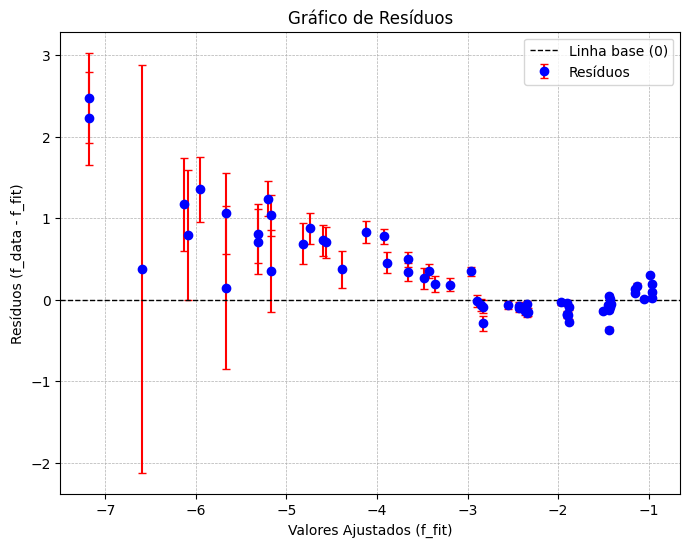

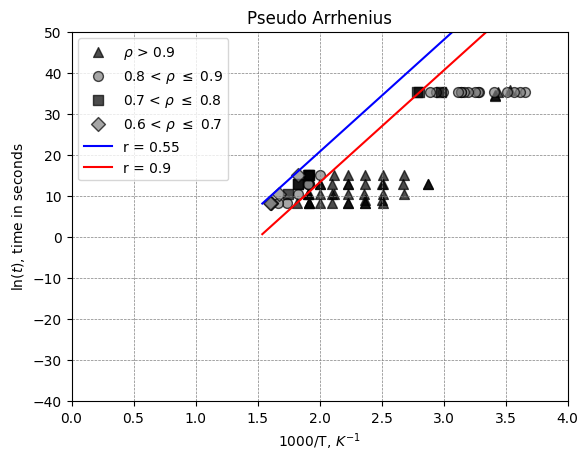

Modelo Paralelo Curvilinear
Tabela de Constantes de Ajuste e Incertezas:
  Parâmetro  Valor Ajustado  Incerteza
0        c0       -5.109328   0.035307
1        c1        0.215785   0.002420
2        c2      -10.551468   0.086561

Tabela de Qualidade do Ajuste:
  Parâmetro       Valor
0        R²    0.895447
1      Chi²  924.614746


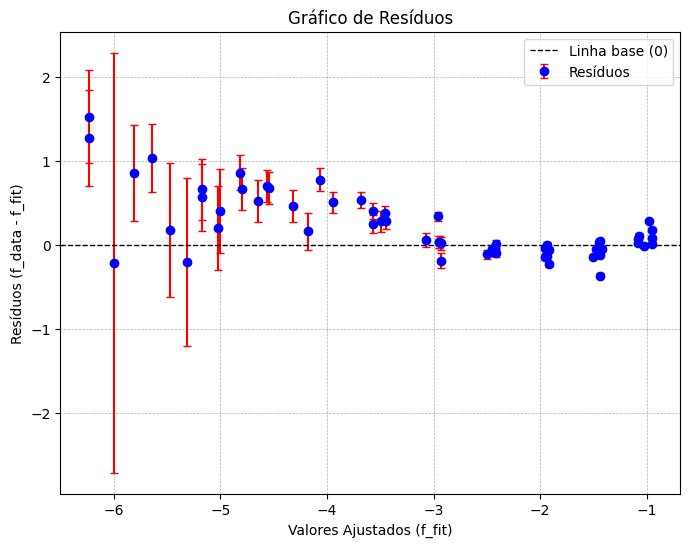

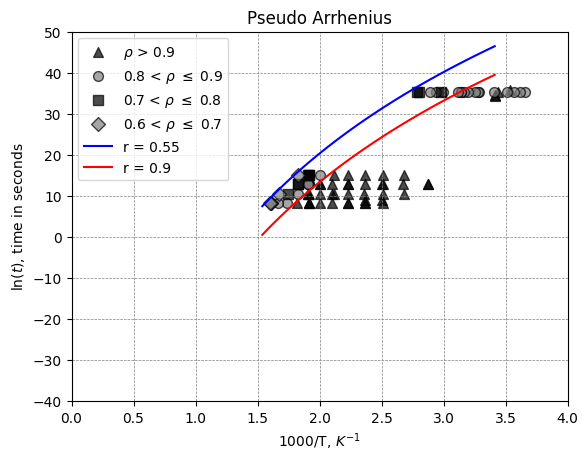

Modelo Fanning Arrhenius
Tabela de Constantes de Ajuste e Incertezas:
  Parâmetro  Valor Ajustado  Incerteza
0        c0       -6.468323   0.192351
1        c1        0.093593   0.003523
2        c2       -6.936484   0.872658
3        c3        0.548254   0.015485

Tabela de Qualidade do Ajuste:
  Parâmetro       Valor
0        R²    0.917840
1      Chi²  427.607329


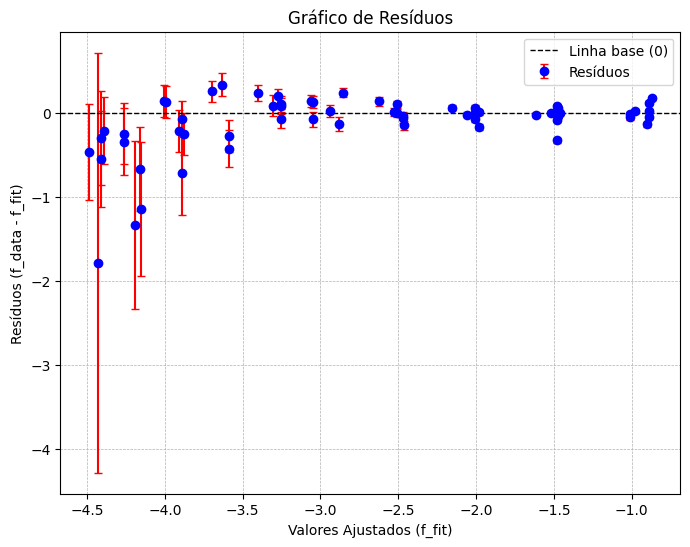

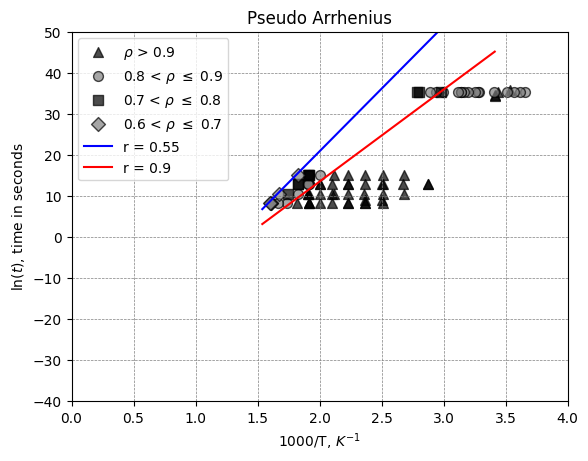

Modelo Fanning Curvilinear
Tabela de Constantes de Ajuste e Incertezas:
  Parâmetro  Valor Ajustado  Incerteza
0        c0       -7.996631   0.337373
1        c1        0.136655   0.006907
2        c2      -13.015017   1.488250
3        c3       -0.627219   0.029911

Tabela de Qualidade do Ajuste:
  Parâmetro       Valor
0        R²    0.924628
1      Chi²  498.929408


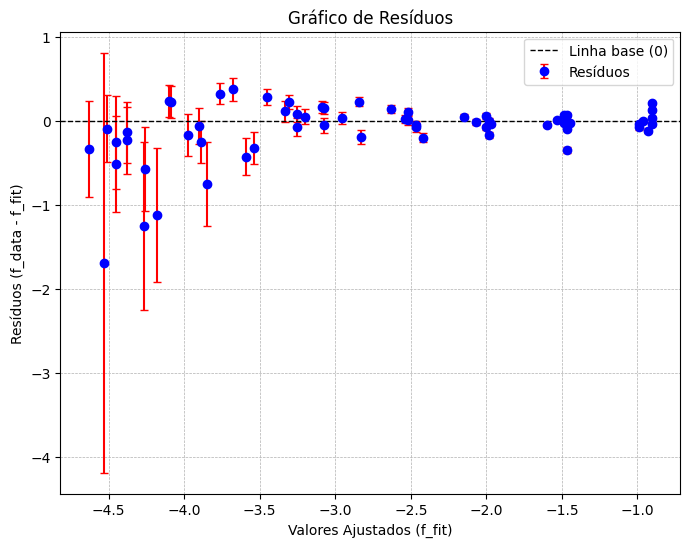

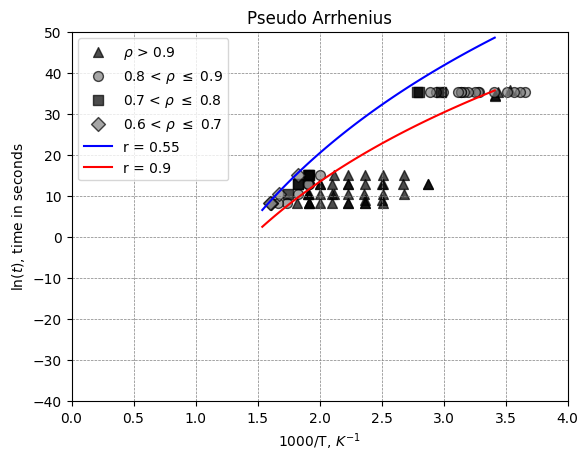

In [17]:
print("Modelo Paralelo-Arrhenius")
initial_params = [5.631, 0.1865, -10.46]
DAM_fit(f_PA,initial_params, lnt_PA)
print("Modelo Paralelo Curvilinear")
initial_params = [-4.910, 0.1944, -9.610]
DAM_fit(f_PC,initial_params, lnt_PC)
print("Modelo Fanning Arrhenius")
initial_params = [-8.518, 0.1266, -20.99, 0.2985]
DAM_fit(f_FA,initial_params, lnt_FA)
print("Modelo Fanning Curvilinear")
initial_params = [-9.449 , 0.1627, -24.58, -0.8626]
DAM_fit(f_FC,initial_params, lnt_FC)